# (1)MacCormack法


In [192]:
import numpy as np
import matplotlib.pyplot as plt

In [193]:
nmax = 300
jmax = 101
dt = 0.002
gamma = 1.4

In [194]:
DIM = 3
# 左
p1 = 1.0
rho1 = 1.0
u1 = 0.0
# 右
p2 = 0.1
rho2 = 0.125
u2 = 0.0

In [195]:
xmin, xmax = -1.0, 1.0
xmid = 0.0
x = np.linspace(xmin, xmax, jmax)
dx = np.mean(np.diff(x))
dtdx = dt / dx

In [196]:
# 状態方程式
def eq_energy(p, rho, u):
    return p / (gamma - 1.0) + (1 / 2) * rho * u**2

def eq_pressure(e, rho, u):
    return (gamma - 1.0) * (e - 0.5 * rho * u**2)

In [197]:
# 初期化
def init_Q():
    Q = np.zeros((jmax, DIM))
    assert len(x) == len(Q)
    Q[x <= xmid, 0] = rho1
    Q[x <= xmid, 1] = rho1 * u1
    Q[x <= xmid, 2] = eq_energy(p=p1, rho=rho1, u=u1)
    Q[x > xmid, 0] = rho2
    Q[x > xmid, 1] = rho2 * u2
    Q[x > xmid, 2] = eq_energy(p=p2, rho=rho2, u=u2)
    return Q

In [198]:
def calc_CFL(Q: np.ndarray):
    all_rho, all_rhou, all_e = Q[:, 0], Q[:, 1], Q[:, 2]
    all_u = all_rhou / all_rho
    all_p = eq_pressure(e=all_e, rho=all_rho, u=all_u)
    all_c = np.sqrt(gamma * all_p / all_rho)
    speed = all_c + np.abs(all_u)
    return np.max(speed) * dtdx

In [199]:
def E_flux(Q: np.ndarray, E: np.ndarray):
    all_rho, all_rhou, all_e = Q[:, 0], Q[:, 1], Q[:, 2]
    all_u = all_rhou / all_rho
    all_p = eq_pressure(e=all_e, rho=all_rho, u=all_u)
    
    E[:, 0] = all_rhou
    E[:, 1] = all_p + all_rhou * all_u
    E[:, 2] = (all_e + all_p) * all_u
    return E

In [200]:
def MacCormark(Q: np.ndarray, eps_c: float):
    # init
    E = np.zeros((jmax, DIM))
    interval = 2
    # 保存用
    store_Q = np.zeros((nmax, jmax, DIM))

    for n in range(nmax):
        # if n%interval == 0:
        #     print("n={0}, CFL={1}".format(n, calc_CFL(Q)))
        _Q = Q.copy()
        
        E = E_flux(Q=Q, E=E)
        for j in range(1, jmax - 1):
            _Q[j] = Q[j] - dtdx * (E[j] - E[j-1])
        
        E = E_flux(Q=_Q, E=E)
        for j in range(1, jmax - 2):
            Q[j] = (1/2) * (Q[j] + _Q[j]) - (1/2) * dtdx * (E[j+1] - E[j])

        _Q = Q.copy()
        for j in range(1, jmax - 1):
            D1 = _Q[j-1] - 2.0 * _Q[j] + _Q[j+1]
            D2 = _Q[j-1] + 2.0 * _Q[j] + _Q[j+1]
            k = eps_c * np.linalg.norm(D1) / np.linalg.norm(D2)
            Q[j] += k * D1

        # 後処理
        store_Q[n] = Q
    return store_Q

In [201]:
Q = init_Q()
store_Q = MacCormark(Q=Q, eps_c=0.2)

## 可視化


In [202]:
# グラフの設定
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.dpi"] = 100

In [203]:
def draw_graph(dim):
    fig = plt.figure()
    for n in range(nmax):
        interval = 50
        if n%interval != 0:
            continue
        b = 0.1
        a = (1 - b) / nmax
        alpha = a * n + b
        plt.plot(x, store_Q[n, :, 0], color="black", alpha=alpha, label="n={0}".format(n))
    plt.legend()
    return fig

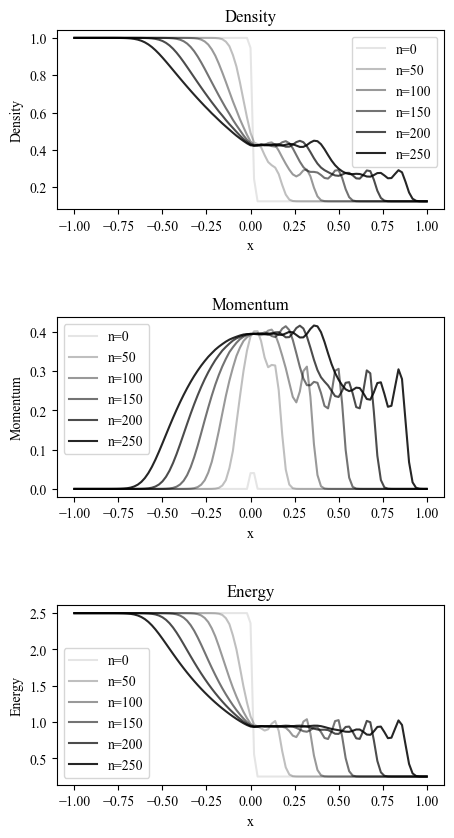

In [204]:
fig = plt.figure(figsize=(5, 10))
plt.subplots_adjust(wspace=0.4, hspace=.6)
axs = [fig.add_subplot(3, 1, i+1) for i in range(DIM)]

name_list = ["Density", "Momentum", "Energy"]
for i, ax in enumerate(axs):
    ax.set_ylabel(name_list[i])
    ax.set_xlabel("x")
    ax.set_title(name_list[i])
    for n in range(nmax):
        interval = 50
        if n%interval != 0:
            continue
        b = 0.1
        a = (1 - b) / nmax
        alpha = a * n + b
        ax.plot(x, store_Q[n, :, i], color="black", alpha=alpha, label="n={0}".format(n))
    ax.legend()

fig.savefig("img/report1/general_result.png")

# 起きている現象

密度に注目する。n=150(0.3秒)以降からグラフの形が、左から順に3段階段上になっていることが顕著になる。この3段はそれぞれ、膨張波と接触面と衝撃波であり、速度はそれぞれ$u-c, u, u+c$である。